<a href="https://colab.research.google.com/github/perfectpanda-works/machine-learning/blob/master/WHAT_IS_TORCH_NN_REALLY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

このチュートリアルでは、MNISTデータセットを利用して、基本的なニューラルネットワークを訓練します。最初はPyTorchのテンソルの機能のみで作成していきます。

また、このチュートリアルは、テンソルの操作の基本を知っていることが前提となっています。

##MNISTデータのセットアップ

MNISTは機械学習の有名なデータセットで、0～9の手書き数字（白黒画像）のデータです。分類問題として、正しく手書き数字を分類できるネットワークの訓練を目指します。

次のプログラム（Python3標準ライブラリのpathlibを利用）で、リクエストを利用して、MNISTデータセットをダウンロードします。

GoogleColaboで実行する場合、ファイルの「data/mnist/」に追加されます。

In [ ]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

ここでダウンロードしたデータセットはnumpy形式で、python固有のpickelで保存されています。そのため、次のプログラムでデータを取り出します。

gzipをopenしたのち、pickel形式のデータを読み込んでいます。

In [ ]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

この状態で、各画像は784個のデータの平坦化された行（１次元の配列）として保存されていますので、28×28の画像として変換する必要があります。

In [ ]:
print(x_train[0].shape)

(784,)


reshapeメソッドで28×28の行列に変換してmatplotlibで表示してみます。

また、x_trainには50000個の手書き文字データが格納されています。

(50000, 784)


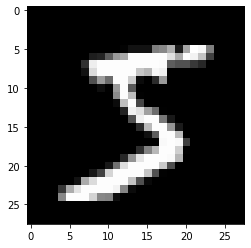

In [ ]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorchでデータを利用するためにnumpyから「torch.tensor」に変換します。

In [ ]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(n)
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

50000
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


#スクラッチでニューラルネットワーク(torch.nnを利用しない)

このチュートリアルを行う前に、ニューラルネットワークについての基本的な知識があることが前提となっています。

まずはニューラルネットワークのパラメータを保持する変数を作成します。

PyTorchの提供するメソッドでランダムな値で埋められたテンソルや、ゼロで埋められたテンソルを作成することができます。そして、そのテンソルをシンプルな線形モデルの重みやバイアスといったパラメータにすることができます。また、Tensorのもっとも重要な特徴は、勾配が計算できるという点です。テンソルに行われた計算を保持できるので、勾配を自動的に計算することができます。

次のプログラムで、ニューラルネットワークの「重み」と「バイアス」パラメータを作成します。

ニューラルネットの「重み」パラメータのためのテンソルは、初期化のすぐ後に「required_grad_()」で計算の追跡する設定にしています。（初期化の計算をした後に追跡開始することで、初期化の計算を含めない点がポイント）

また、重みのパラメータは、「Xavier　initialisation」という初期化方法を利用しています。

「バイアス」は、ゼロで初期化するとともに、「required_grad」フラグをTrueにしています。

In [ ]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

PyTorchの自動的に勾配を計算（自動微分）してくれるおかげで、通常のPythonの関数などが利用できます。

次に、「活性化関数」を作成します。手動で「log_softmax」を定義しています。これは、Pythonの関数として定義します。

そして、「model」では、ニューラルネットワークのモデル自体を定義しています。モデルといっても、今回は、順伝播が行われるような式を定義しているだけになります。重みと入力テンソルを掛け合わせて、バイアスを足したものを活性化関数のlog_softmaxに入れ、出力値をリターンするようなモデルです。

In [ ]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

上のプログラムの「@」は内積演算（行列積）を表しています。

そして、モデルには、バッチ単位でデータを渡します。（今回は64枚の画像）「xb」には64枚の画像が入ってくるということです。

実際には、xbが（64×784）の行列、そして、weightsは(784×10)の行列となります。

In [ ]:
bs = 64  # バッチサイズ

xb = x_train[0:bs]  # ミニバッチサイズ
preds = model(xb)  # 順伝播で予測
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.3829, -2.5776, -1.7291, -1.9857, -2.5503, -2.5155, -2.2194, -2.5737,
        -2.5830, -2.3260], grad_fn=<SelectBackward>) torch.Size([64, 10])


「xb」には、訓練用画像「x_train」から0〜63枚目の画像（計64枚）が格納されます。

そして、その「xb」をmodelに入れることで、modelに計算をさせ、予測値をえます。（順伝播）

この予測値には、勾配も含まれていることが確認できます。これは後の逆伝播で利用します。

それでは、損失関数として「負の対数尤度関数（NLL)」を定義します。これは、Python標準の関数で作成しています。

In [ ]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

それでは、損失を確認してみます。

In [ ]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3737, grad_fn=<NegBackward>)


同様に、このモデルの精度を確認してみます。



In [ ]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [ ]:
print(accuracy(preds, yb))

tensor(0.0469)


これで、訓練ループを実装できます。それぞれのループでは、次のことを行います。

・ミニバッチでデータを選択

・モデルで予測

・誤差を求める

・逆伝播をして勾配を求める

・重みを更新する

重みを更新する際には、重みの更新の計算を追跡しないようにtorch.no_grad()で囲みます。また、次のループに入る前に勾配をリセットするためにgrad_zero()を呼び出す必要があります。

学習率は「lr」、訓練回数は「epochs」で指定します。

（Python標準のデバッガも利用できるとのことです。）

In [ ]:
from IPython.core.debugger import set_trace

lr = 0.5  # 学習率
epochs = 2  # 訓練のエポック数

print("n")
print(n)
print("bs")
print(bs)

#エポック回数分繰り返す
for epoch in range(epochs):
    batch_num=0
    #ミニバッチのループ
    #//は切り捨て除算
    for i in range((n - 1) // bs + 1):#(49999÷64)+1=782.23の切り捨て回数分のミニバッチ
        batch_num = batch_num + 1
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        #勾配降下法で重みの更新(式を手動で定義)
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

print("mini_batch_num")
print(batch_num)

n
50000
bs
64
mini_batch_num
782


今回は、もっともミニマムなニューラルネットワークを作成しました。これは、ロジスティック回帰であり、隠れ層のないネットワークです。

訓練後の損失と精度を確認してみます。

In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0824, grad_fn=<NegBackward>) tensor(1.)


#リファクタリング

##torch.nn.functionalを使う


これから、スクラッチで作成したプログラムをpytorchのnnクラスを利用してより簡潔で柔軟なプログラムになるようにリファクタリングを行います。

ここからのステップでは、プログラムをより短く、理解しやすい形に変更していきます。

いちばん簡単なステップとしては、手動で定義していた損失関数を「torch.nn.functional」で置き換えることです。「torch.nn.functional」は一般的に「F」という名前空間でimportされます。

（Functionalは、「as F」とするのが一般的のようです。）

損失関数として、「負の尤度関数(negative log likelihood)」または「尤度関数(log softmax)」を利用している場合、PyTorchでは「F.cross_entropy」関数でカバーしています。これを利用して、損失関数をモジュールを利用して簡潔に記述することができます。

In [ ]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

同じ損失と同じ精度が算出されることを確認しましょう。

In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0824, grad_fn=<NllLossBackward>) tensor(1.)


##nn.Moduleでリファクタリング

次に、訓練ループを整理するために、「nn.Module」と「nn.Parameter」を利用します。

nn.Moduleのサブクラスとしてクラスを定義することで利用します。サブクラスでは、「重み、バイアス」といったネットワークの訓練パラメータを保持し、順伝播をメソッドとして実装していきたいです。nn.Moduleには、このようなサブクラスを作成するための「.Parameter()」や「zero_grad()」といった属性やメソッドが存在します。

In [ ]:
#nnをimport
from torch import nn

#nn.Moduleを継承したMnistLogisticクラス
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        #コンストラクタで重み、バイアスの初期化
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    #forwardメソッドの定義
    def forward(self, xb):
        return xb @ self.weights + self.bias

クラスのコンストラクタでXavier　initialisationとバイアスのゼロ初期化を行うようになりました。

また、forwardをクラスのメソッドとして定義しました。nn.Moduleのクラスを利用することで、テンソルの追跡も自動的に行われるので、手動で行っていた時のようにRequired_gradを気にする必要もなくなりました。

定義したモデルをインスタンス化します。

In [ ]:
model = Mnist_Logistic()

今までの記載方法と同じ記載で損失を計算することができます。

nn.Moduleのオブジェクトは関数のように使用することができます。関数のように呼び出すことで、自動的にforwardメソッドを実行してくれるようになっています。

In [ ]:
print(loss_func(model(xb), yb))

tensor(2.3372, grad_fn=<NllLossBackward>)


以前の訓練方法では、それぞれのパラメータ（重み、バイアス）を変数名で指定して更新を行い、それぞれのパラメータの勾配を明示的に初期化を行わなければいけませんでした。

In [ ]:
#いままでの手動での勾配降下法の実装
#with torch.no_grad():
#    weights -= weights.grad * lr
#    bias -= bias.grad * lr
#    weights.grad.zero_()
#    bias.grad.zero_()

nn.Moduleクラスを導入することで、「model.parameters()」でモデル全体のパラメータにアクセスができ、「model.zero_grad() 」でモデル全体のパラメータの勾配を一括で初期化できるようになりました。これは、もっと複雑なネットワークを定義するときにとても役に立ちます。重みの更新忘れなどの人為的ミスも防ぐことになります。

In [ ]:
#with torch.no_grad():
#    for p in model.parameters(): p -= p.grad * lr
#    model.zero_grad()

このparameters()とzero_grad()を使った勾配降下法で訓練関数fit()を作成してみます。

In [ ]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [ ]:
print(loss_func(model(xb), yb))

tensor(0.0827, grad_fn=<NllLossBackward>)


##nn.Linearでリファクタリング

次に、モデルの定義の中で、「self.weights」や「self.bias」と行った変数を定義して初期化していました。そして、「xb @ self.weights + self.bias」と順伝播の式を手動で定義していました。

中間層が増加すると、「weights」や「bias」と行った変数も中間層分増加することになり、順伝播の式もより複雑になっていきます。

今回のような線形な層の場合、nn.Linearを利用して、簡潔に記載することができます。線形の層以外の畳み込み層など一般的に利用されるものもpytorchに存在し、とても早く実装することができるようになります。

In [ ]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        #入力が784次元、出力が10次元の線形の層を定義
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

このクラスは、以前と同様のプログラムでインスタンス化して、損失を計算することができます。

In [ ]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3883, grad_fn=<NllLossBackward>)


先ほどリファクタリングした訓練用の関数であるfitも同様に利用することができます。

In [ ]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0820, grad_fn=<NllLossBackward>)


##optimでリファクタリング

Pytorchには、さまざまな最適化アルゴリズムを含むパッケージtorch.optimもあります。各パラメーターを手動で更新する代わりに、オプティマイザーのstepメソッドを利用できます。

手動でコーディングした最適化手順をそのまま置き換えてみます。

In [ ]:
#以前の手動でのパラメータ更新
#with torch.no_grad():
#    for p in model.parameters(): p -= p.grad * lr
#    model.zero_grad()

これを単純に次のプログラムに置き換えます。

In [ ]:
#opt.step()
#opt.zero_grad()

実際に修正したプログラムをみてみましょう。

In [ ]:
from torch import optim

モデルとオプティマイザを作成するための小さな関数を作成します。

In [ ]:
#この関数を呼び出すと、モデルとオプティマイザのインスタンス化ができます。
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

#ここで呼び出します。
model, opt = get_model()
print(loss_func(model(xb), yb))

#fit()という関数にまとめていた訓練部分
#今回はとりあえず普通に記載しています。
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        #重みの更新がこのように簡潔になる
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2884, grad_fn=<NllLossBackward>)
tensor(0.0823, grad_fn=<NllLossBackward>)


##Datasetでリファクタリング

PyTorchには抽象的なデータクラスがあります。

データセットは、``__len__``と``__getitem__``をインデックス付けする方法を持つものであればなんでもOKとのことです。
（ここは、カスタムDatasetを作成するチュートリアルが詳しいので、また追加で勉強する必要があります。ここでは、Datasetクラスで``__len__``と``__getitem__``が呼び出せるようになっているという理解で良いかと思います。DatasetのサブクラスとしてカスタムDatasetを作成する方法が`This tutorial <https://pytorch.org/tutorials/beginner/data_loading_tutorial.html>`で確認できます。


PyTorchのTensorDatasetは、データセットをラップするテンソルです。これは、インデックス付けの長さと方法を定義することにより、テンソルの最初の次元に沿って反復、インデックス付け、およびスライスする方法も提供します。これにより、トレーニング中に同じ行で独立変数と従属変数の両方にアクセスしやすくなります。

ここは、TensorDatasetを利用することで、データと答えの紐付けができて管理しやすくなる、という理解で良いかと思います。


In [ ]:
from torch.utils.data import TensorDataset


x_trainとy_trainの両方を1つのTensorDatasetに組み合わせることができます。これにより、繰り返し処理やスライスが容易になります。

（チュートリアルの一番最初にpickelで取得したデータです。x_trainには画像データ、y_trainには答えデータが格納されています。）

In [ ]:
#TensorDatasetで画像と答えラベルをまとめる
train_ds = TensorDataset(x_train, y_train)

以前のプログラムでは、ミニバッチで画像データ「x」と答えデータ「y」は別のデータとして紐づけていました。

In [ ]:
#以前のミニバッチへデータを読み込むプログラム
#xb = x_train[start_i:end_i]
#yb = y_train[start_i:end_i]

In [ ]:
#xbとxyの読み込みを1行に
xb,yb = train_ds[i*bs : i*bs+bs]

以下のように、訓練ループに組み込みます。

In [ ]:
model, opt = get_model()

#訓練ループの修正
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #このように１行で書くことができるように
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0814, grad_fn=<NllLossBackward>)


このDatasetでは、プログラムの記載する分量としては増えているのですが、この後のDataLoaderを利用することでバッチ単位でのデータ管理がとても簡単になります。

##DataLoaderでリファクタリング

PyTorchのDataLoaderはバッチの管理を行います。DataLoaderはDatasetから作ることができます。マニュアルでデータを切り取るようなプログラム「``train_ds[i*bs : i*bs+bs]``」を利用しなくても、DataLoaderが自動的にミニバッチのデータを与えてくれるようになります。

In [ ]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

DataLoaderには、TensorDatasetとバッチサイズを与えるだけになります。

以前のプログラムでは以下のようになっていました。

In [ ]:
#for i in range((n-1)//bs + 1):
#    xb,yb = train_ds[i*bs : i*bs+bs]
#    pred = model(xb)

forループのバッチサイズ毎に割り算したり、めんどくさいイメージがありました。DataLoaderを利用すると次のようになります。

In [ ]:
#for xb,yb in train_dl:
#    pred = model(xb)

DataLoaderまでを利用した訓練ループは次のようになります。

In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0817, grad_fn=<NllLossBackward>)



Pytorchのnn.Module、nn.Parameter、Dataset、DataLoaderのおかげで、トレーニングループが劇的に小さくなり、理解しやすくなりました。

#validationの追加

一番最初のpickelデータの読み込みのところで、「x_valid」「y_valid」というデータも読み込んでいましたが、利用していませんでした。検証データという名前でこのセクションから利用することになります。

（validationは、検証データと言って、訓練データに利用していないデータでモデルの損失を計算することで、過学習がどうかを見分けることができるようになります。）

前のセクションでは、訓練ループのためにデータを使うだけでした。実際には、モデルが過学習していないかを判断するために「Validation set」も作成する必要があります。

バッチと過学習の相関関係を防ぐために、データをシャッフルすることも重要です。一方で、検証セット（validation set）のシャッフルをしても、モデルから出力される損失は同じになるので、意味がありません。

検証セット（validation set）には、トレーニングセットの2倍のバッチサイズを使用します。これは、検証セットがバックプロパゲーションを必要としないため、メモリ消費が少ないためです（勾配計算を保存する必要はありません）。これを利用して、より大きなバッチサイズを使用し、損失をより迅速に計算します。

・訓練データ：データをシャッフル

・検証データ：データをシャッフルしない、バッチサイズ２倍、勾配計算なし



In [ ]:
#訓練データ
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

#検証データ
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

各エポックの終わりに検証データでの損失を計算し、表示します。

トレーニングの前に常にmodel.train（）を呼び出し、推論の前にmodel.eval（）を呼び出すことに注意してください。これらはnn.BatchNorm2dやnn.Dropoutなどのレイヤーによって使用され、これらの異なるフェーズに対する適切な動作を保証します。

In [ ]:
model, opt = get_model()

#現在２エポックで検証中
for epoch in range(epochs):
    #モデルを訓練モードに
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    #モデルを検証モードに
    model.eval()
    #検証データで損失を求めます。
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    #検証データでの損失の表示
    print(str(epoch + 1) + "エポック目")
    print("Loss：{:.4f}" .format(valid_loss.item() / len(valid_dl)))

1エポック目
Loss：0.2950
2エポック目
Loss：0.2785


#Create fit()とget_data()

損失計算という観点から、訓練データと検証データで２回同じことをしているので「loss_batch」という関数を作成してまとめます。

In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

「opt」という引数がポイントで、トレーニングデータの損失を計算するときは、optにオプティマイザを渡します。それによって、訓練データの場合には、そのまま逆伝播、重みの更新、初期化と処理が続きますが、検証データの場合はモデルの損失計算のみを行うような関数となっています。

ここで、訓練の関数を「fit」としてまとめます。検証データで損失を計算する機能も入りました。

In [ ]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        #訓練データ
        model.train()
        for xb, yb in train_dl:
            #ここでloss_batch
            loss_batch(model, loss_func, xb, yb, opt)

        #検証データ
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                #ここでloss_batch
                #アスタリスク：unpack リスト内包表記：[式 for in]
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(str(epoch + 1) + "エポック目")
        print("Loss：{:.4f}" .format(val_loss))

検証データの損失計算部分はわかりにくいです。まずは、loss_batch周りがどのようなデータを吐き出しているかを確認してみます。ここでは、Python3の「リスト内包表記」という方法でloss_batchを回しています。リスト内包表記では、式　＋　forループという書き方をします。そこで、最終的に以下のプログラムで表示するデータが得られます。リストの中に、loss_batchの返り値２つが並んでいる形です。

リスト形式で保存されているので、値としてloss_batchの答えを1組づつを取り出すため、アスタリスクでアンパックを行います。そして最後にzip関数で1組ごとに取り出してlossesには損失値を、numsにはデータ数を入れていきます。

In [ ]:
#リスト内包表記で出力されるデータ
print([loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])

losses_test, nums_test = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )

#lossesに格納されるデータ
print(losses_test)
#numsに格納されるデータ
print(nums_test)

[(0.30248913168907166, 128), (0.4359905421733856, 128), (0.46118608117103577, 128), (0.43608739972114563, 128), (0.5143918991088867, 128), (0.2649153172969818, 128), (0.23582731187343597, 128), (0.14742805063724518, 128), (0.1691281646490097, 128), (0.3396688401699066, 128), (0.2540515065193176, 128), (0.22108709812164307, 128), (0.2086421400308609, 128), (0.3128027021884918, 128), (0.17792898416519165, 128), (0.4050435423851013, 128), (0.5714041590690613, 128), (0.33601051568984985, 128), (0.37412694096565247, 128), (0.18012578785419464, 128), (0.31404775381088257, 128), (0.4030842185020447, 128), (0.6009613871574402, 128), (0.5017997622489929, 128), (0.26975366473197937, 128), (0.24492301046848297, 128), (0.06712604314088821, 128), (0.41023939847946167, 128), (0.3157550096511841, 128), (0.2340921014547348, 128), (0.3482358157634735, 128), (0.44842538237571716, 128), (0.30860665440559387, 128), (0.1631796658039093, 128), (0.30612605810165405, 128), (0.4038170278072357, 128), (0.151941

トレーニングセットと検証セットのデータローダーをまとめて返す「get_data」関数も定義します。

In [ ]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

これで、データローダーを取得して、モデルを訓練させる流れを３行で記載できるようになりました。

In [ ]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

1エポック目
Loss：0.3395
2エポック目
Loss：0.2940


#CNNへの切り替え

次に、３つの畳み込み層をもつニューラルネットワークを作成します。

畳み込み層としてPyTorchにあらかじめ定義してある「Conv2d」クラスを利用します。これから作成する畳み込み層は３層とします。それぞれの畳み込み層は、活性化関数「ReLU」を通ります。そして、最後に「アベレージプーリング」を行います。（PyTorchの「view」はnumpyでいう「reshape」メソッドです。

In [ ]:
#畳み込みニューラルネットワークのモデル定義
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        #print(xb.shape) →[64,10,1,1]
        return xb.view(-1, xb.size(1))#print(xb.view(-1, xb.size(1)).shape)→[64,10]

#学習率を変数「lr」に格納
lr = 0.1

次に、モデルをインスタンス化して、オプティマイザを作成、訓練のfit関数を実行します。

勾配降下法（SGD）の「momentum」パラメータを設定しています。このパラメータを設定すると、前回の重みに「momentum」倍して加算するというMomentumSGDと呼ばれる方法になります。一般的に、訓練が早くなるようです。今回のチュートリアルでは「momentum」を0.9としたSGDを利用するようです。

In [ ]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

1エポック目
Loss：0.3743
2エポック目
Loss：0.2369


#nn.Sequential


torch.nnには、コードを単純化するために使用できる「sequential」という便利なクラスがあります。
Sequentialオブジェクトは、その中に含まれる各モジュールを順次実行します。
これは、ニューラルネットワークを記述する最も簡単な方法です。

また、特定の関数からカスタムレイヤーを簡単に定義できます。
たとえば、PyTorchにはビューレイヤーがないため、ネットワーク用にビューレイヤーを作成する必要があります。 Lambdaは、Sequentialでネットワークを定義するときに使用できるレイヤーを作成します。
（Lambdaクラスを利用して次のようにSequentialでのオリジナルの層が定義できます。）

In [ ]:
#LambdaでSequentialに与える空の層を定義する。
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

#実際に層の中で行う動作を関数として記載、Lambdaクラスの入力となる。
def preprocess(x):
    return x.view(-1, 1, 28, 28)

ビューレイヤー、データを「view」で変換するような層をnn.Moduleを継承したLambdaというクラスで作成しています。また、「preprocess」という関数でviewメソッドを呼び出し、画像データの形式へと変換を行なっています。（ここでは４階のテンソルの形式に変換）

In [ ]:
#Sequentialで畳み込みニューラルネットワークモデルを定義
model = nn.Sequential(
    #先ほど定義したLambdaクラスにpreprocessメソッドで入力することで層のように振る舞う
    #Lambda①
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    #Lambda②
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

1エポック目
Loss：0.3142
2エポック目
Loss：0.2261


Sequentialは、層の流れと処理の流れがそのまま記載されているので直感的に理解しやすい形になっています。

Lambdaについてもう少し考えてみます。

定義したLambdaクラスはSequentialでモデルを定義する際に、先のプログラムのように利用します。Sequentialの一番最初のデータ変換として利用しています(Lambda①)。また、出力時にテンソルの形状を変更するのにも利用しています（Lambda②）。

Lambda②のように関数として定義していなくても、Pythonの関数である「lambda関数」を利用してLambdaクラスの引数として入力することも可能です。

Lambdaクラスで層を作成するイメージは、

①Sequentialに層として与えるための空の層をLambdaクラスで作成

②Lambdaクラスに引数として関数を与えることでオリジナルの動作をする

といった感じでしょうか。

Sequentialの項目というよりは、SequentialでのLambdaクラスの使い方といった内容になりました。

#DataLoaderのラッピング

今まで作成してきたCNNは簡潔にできていますが、MNISTデータでのみうまく機能します。
その原因としては

・入力を28×28のデータであると想定

・最後の「Average Pooling」のカーネルサイズが4×4である

これらを仮定しているため、MNIST画像データに特化しているといえます。

このような仮定を取り除き、１チャンネルの２次元画像で機能するようなモデルに変更していきます。

まずは、最初のLambdaレイヤーを取り除き、ここで行っていたデータの前処理を「ジェネレータ」



In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

次に、nn.AvgPool2dをnn.AdaptiveAvgPool2dで置き換えます。これにより、入力テンソルではなく、必要な出力テンソルのサイズを定義できます。その結果、モデルは任意のサイズの入力で機能します。

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

1エポック目
Loss：0.1890
2エポック目
Loss：0.1732


#GPUを使う

CUDA対応のGPUが利用できる環境であれば、GPUを利用して、より早く演算ができるようになります。
まずは、CUDAが利用できるかを確認します。

Google Colaboの場合は、「ランタイム」->「ランタイムのタイプの変更」->「ハードウェアアクセラレータ」をGPUに変更しておきます。

In [ ]:
print(torch.cuda.is_available())

True


次に、「デバイスオブジェクト」を作成します。

In [ ]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

次に、バッチのデータをGPUへ移動させるため、「preprocess」関数でデータをGPUへ移動させるように書き換えます。

In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

モデルもGPUを指定しておきます。これで、GPUで動作させる準備が整いました。

In [ ]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

訓練を実行してみると、前より早く訓練が行われるのがわかります。

In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

1エポック目
Loss：0.1591
2エポック目
Loss：0.1912


#まとめ

これで、Pytorchを使用して多くのタイプのモデルをトレーニングするために使用できる一般的なデータパイプラインとトレーニングループができました。

チュートリアルでは、基本的な内容のみで、さらに「データ拡張、ハイパーパラメータ調整、モニタリングト​​レーニング、転移学習」など、追加したいことがたくさんあります。これらの機能はfastaiライブラリで利用できます。

torch.nn
 Modules：関数のように動作する呼び出し可能オブジェクトを作成し、状態（ニューラルネットの層の重みなどを含めることもできます。重みの勾配を０にしたり、パラメータの更新のためのループしたりできます。
 
 Parameter:バックプロップ中に更新が必要な重みがあることをモジュールに通知するテンソルのラッパー。 require_grad属性が設定されたテンソルのみが更新されます。

 Functional：活性化関数、損失関数など、および畳み込み層や線形層などの非ステートフルバージョンの層を含むモジュールです。通常は慣例によりF名前空間にインポートされます。

torch.optim：SGDなどのオプティマイザーが含まれ、バックワードステップ中にパラメーターの重みを更新します


Dataset：TensorDatasetなどのPytorchで提供されるクラスを含む、__ len__および__getitem__を持つオブジェクトの抽象インターフェースです。


DataLoader：任意のデータセットを受け取り、データのバッチを返すイテレータを作成します。
